In [ ]:
# importing the necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
import nltk
nltk.download('stopwords')
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D,Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
import nltk
import re
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# loading the dataset
df_train = pd.read_csv("training_task_b_source_tweets.csv")
df_test = pd.read_csv("test_task_b_tweets.csv")

In [ ]:
df_train.head()

,id,in_reply_to_status_id_str,text,user.verified,user.followers_count,retweet_count,favorite_count,entities.hashtags,entities.urls,label
0,552783667052167168,NaN,France: 10 people dead after shooting at HQ of...,True,129573,486,38,"[{'indices': [74, 87], 'text': 'CharlieHebdo'}]",[],true
1,552785375161499649,NaN,BREAKING: 10 reportedly shot dead at Paris HQ ...,True,972167,128,5,[],"[{'url': 'http://t.co/5F1DOwzoCQ', 'indices': ...",true
2,552791196247269378,NaN,BREAKING: At least 10 killed in shooting at Fr...,True,3029912,295,78,[],"[{'url': 'http://t.co/mnAeA7j7fY', 'indices': ...",true
3,552791578893619200,NaN,Eleven dead in shooting at Paris offices of sa...,True,3091451,338,28,[],"[{'url': 'http://t.co/gOtSqbwROc', 'indices': ...",true
4,552792544132997121,NaN,BREAKING Charlie Hebdo latest: 11 dead 10 woun...,True,973212,203,32,[],"[{'url': 'http://t.co/kjW3uwCV0f', 'indices': ...",true


In [ ]:
df_train.label.unique()

array(['true', 'false', 'unverified'], dtype=object)

In [ ]:
#dropping the unwanted columns and converting the text into lower
df_train.drop(df_train.columns[[0,1,3,4,5,6,7,8]], axis = 1, inplace = True)
df_test.drop(df_test.columns[[0,1,3,4,5,6,7,8]], axis = 1, inplace = True)

In [ ]:
df_train.head()

,text,label
0,France: 10 people dead after shooting at HQ of...,true
1,BREAKING: 10 reportedly shot dead at Paris HQ ...,true
2,BREAKING: At least 10 killed in shooting at Fr...,true
3,Eleven dead in shooting at Paris offices of sa...,true
4,BREAKING Charlie Hebdo latest: 11 dead 10 woun...,true


In [ ]:
import nltk
import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Applying the necessary preprocessing techniques
def getLemmText(text):
 tokens=word_tokenize(text)
 lemmatizer = WordNetLemmatizer()
 tokens=[lemmatizer.lemmatize(word) for word in tokens]
 return ' '.join(tokens)
def stop_words(text):
  text = REPLACE_BY_SPACE_RE.sub(' ', text)
  text = BAD_SYMBOLS_RE.sub('', text)
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  return text
def getStemmText(text):
 tokens=word_tokenize(text)
 ps = PorterStemmer()
 tokens=[ps.stem(word) for word in tokens]
 return ' '.join(tokens)

In [ ]:
df_train['text'] = list(map(stop_words,df_train['text']))
df_train['text'] = list(map(getLemmText,df_train['text']))
df_train['text'] = list(map(getStemmText,df_train['text']))


df_test['text'] = list(map(stop_words,df_test['text']))
df_test['text'] = list(map(getLemmText,df_test['text']))
df_test['text'] = list(map(getStemmText,df_test['text']))

In [ ]:
# converting the categorical text values into label encoding
label_encoder = preprocessing.LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train.label.values)
df_test['label'] = label_encoder.fit_transform(df_test.label.values)

In [ ]:
ytrain = df_train["label"]
ytest = df_test["label"]
xtrain = df_train["text"]
xtest = df_test["text"]

In [ ]:
# Loading the pre-trained GLOVE embeddings
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in tqdm(f):
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()

2449it [00:00, 50011.69it/s]


In [ ]:
# defining the necessary parameters for the glove text vector
VOCABULARY_SIZE,MAX_LENGTH = 2000,60

In [ ]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(xtrain) + list(xtest))

In [ ]:
xtrain_sequence = tokenizer.texts_to_sequences(xtrain)
xtest_sequence = tokenizer.texts_to_sequences(xtest)

In [ ]:
# padding the input text
xtrain_padding = sequence.pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)
xtest_padding = sequence.pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)
word_index = tokenizer.word_index

In [ ]:
# converting the word embedding into embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
  embedding_matrix[i] = embedding_vector

100%|██████████| 1724/1724 [00:00<00:00, 506016.80it/s]


In [ ]:
# Defining the model with BiLSTM and feed forward neural networks with dense layers having relu activation and output with softmax activation
model = Sequential()
model.add(Embedding(len(word_index) + 1,100,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           172500    
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 100)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1024)              205824    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1

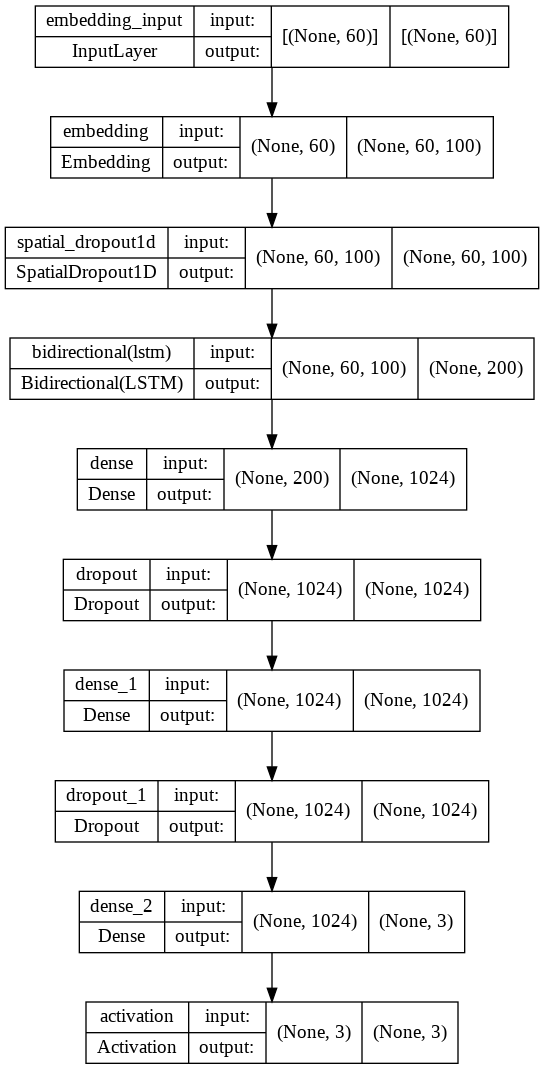

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# converting the target label into categorical
ytrain_encode = np_utils.to_categorical(ytrain)
ytest_encode = np_utils.to_categorical(ytest)

In [ ]:
# training the model with necessary epoch and batch size
history = model.fit(xtrain_padding, y=ytrain_encode, batch_size=512, epochs=10, verbose=1, validation_data=(xtest_padding, ytest_encode))

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 1.0923 - accuracy: 0.3603 - val_loss: 1.1033 - val_accuracy: 0.3929
Epoch 2/10
1/1 [==============================] - 1s 650ms/step - loss: 1.0918 - accuracy: 0.4343 - val_loss: 1.1107 - val_accuracy: 0.3929
Epoch 3/10
1/1 [==============================] - 1s 691ms/step - loss: 1.0707 - accuracy: 0.4512 - val_loss: 1.1220 - val_accuracy: 0.3929
Epoch 4/10
1/1 [==============================] - 1s 688ms/step - loss: 1.0757 - accuracy: 0.4377 - val_loss: 1.1357 - val_accuracy: 0.3929
Epoch 5/10
1/1 [==============================] - 1s 672ms/step - loss: 1.0636 - accuracy: 0.4444 - val_loss: 1.1516 - val_accuracy: 0.3929
Epoch 6/10
1/1 [==============================] - 1s 697ms/step - loss: 1.0614 - accuracy: 0.4714 - val_loss: 1.1689 - val_accuracy: 0.3929
Epoch 7/10
1/1 [==============================] - 1s 674ms/step - loss: 1.0580 - accuracy: 0.4512 - val_loss: 1.1848 - val_accuracy: 0.3929
Epoch 8/10
1/1 [=====

In [ ]:
# evaluating the model
score = model.evaluate(xtest_padding, ytest_encode, verbose=1)

2/2 [==============================] - 0s 41ms/step - loss: 1.2155 - accuracy: 0.3929


In [ ]:
# calculating the f1 score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(xtest_padding)
y_pred = np.argmax(y_pred1, axis=1)
print(f1_score(ytest, y_pred , average="macro"))

0.18803418803418803


In [ ]:
from sklearn.metrics import mean_squared_error
import math
y_true = [np.argmax(val) for val in ytest]
conf = []
for i in range(len(ytest)):
  conf.append(max(y_pred1[i]))
RMSE = mean_squared_error([1]*len(conf), conf,squared = False)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.5666108652214216
